In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from imp import reload
import torch.nn as nn
import os

import sys
sys.path.append("..")
import vnn
import vec_models
import nonvec_models
import train_models
from scipy.stats import pearsonr
reload(vnn)


<module 'vnn' from '../vnn.py'>

In [2]:
#Make vectorized inputs
#(unvectorized inputs are called mnist_data and cifar_data)

train_loader, test_loader = train_models.load_cifar(shuffle_train=False)
for cifar_data, cifar_labels in train_loader:
    break
    
cifar_nonvec_input_conv = cifar_data
cifar_nonvec_input_flat = nn.Flatten()(cifar_data)
cifar_vec_input_conv = vnn.expand_input_conv(cifar_data, 10)
cifar_vec_input_flat = vnn.expand_input(nn.Flatten()(cifar_data), 10)

train_loader, test_loader = train_models.load_mnist(shuffle_train=False)
for mnist_data, mnist_labels in train_loader:
    break
    
mnist_nonvec_input_conv = mnist_data
mnist_nonvec_input_flat = nn.Flatten()(mnist_data)
mnist_vec_input_conv = vnn.expand_input_conv(mnist_data, 10)
mnist_vec_input_flat = vnn.expand_input(nn.Flatten()(mnist_data), 10)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
def compute_angle(g1, g2):
    n1 = np.linalg.norm(g1, axis=1)
    n2 = np.linalg.norm(g2, axis=1)
    good_mask = (n1 > 1e-6) & (n2 > 1e-6)
    if np.sum(good_mask) == 0:
        return np.nan
    g1, g2 = g1[good_mask], g2[good_mask]
    cos_angles = (g1*g2).sum(axis=1) / (np.linalg.norm(g1, axis=1) * np.linalg.norm(g2, axis=1))
    angles = np.rad2deg(np.arccos(cos_angles))
    mean_angle = np.mean(angles)
    return mean_angle
    

def compute_alignment_angles_vec(model_dir, make_model_fn, input, labels):
    batch_size = len(input)
    epoch_files = os.listdir(model_dir)
    epochs = np.sort([int(name.split('.')[0].split('_')[1]) for name in epoch_files])
    num_checkpoints = len(epochs)
    angles_all_epochs = []
    for epoch_idx in range(len(epochs)):
        print(epoch_idx)
        epoch = epochs[epoch_idx]
        checkpoint = torch.load(model_dir + "/epoch_{}.pt".format(epoch))
        model = make_model_fn()
        model.load_state_dict(checkpoint["model_state_dict"])
        nonlin_layers = [i for i, layer in enumerate(model) if layer.__class__.__name__ in ('tReLU', 'ctReLU')]
        vnn.zero_grads(model)
        with torch.no_grad():
            output = model(input)[..., 0]
        g_vals = vnn.set_model_grads(model, output, labels, learning_rule="bp", reduction="mean", return_g=True)
        g_vals = g_vals[::-1][1:]
        g_vals = [g_vals[i].view(batch_size, -1).numpy() for i in nonlin_layers]
        
        epoch_angles = np.array([compute_angle(g_vals[i], np.ones_like(g_vals[i])) for i in range(len(g_vals))])
        print(epoch_angles)
        angles_all_epochs.append(epoch_angles)
        
    return np.array(angles_all_epochs)

def compute_alignment_angles_nonvec(model_dir, make_model_fn, input, labels):
    batch_size = len(input)
    epoch_files = os.listdir(model_dir)
    epochs = np.sort([int(name.split('.')[0].split('_')[1]) for name in epoch_files])
    num_checkpoints = len(epochs)
    angles = None
    loss_fn = nn.CrossEntropyLoss(reduction="mean")
    angles_all_epochs = []
    for epoch_idx in range(len(epochs)):
        epoch = epochs[epoch_idx]
        checkpoint = torch.load(model_dir + "/epoch_{}.pt".format(epoch))
        model = make_model_fn()
        nonlin_layers = [i for i, layer in enumerate(model.sequential) if layer.__class__.__name__ == 'aReLU']
        #run once to instantiate feedback matrix variable
        _ = model(input, learning_rule="df")
        #load feedback matrix from epoch 10 if we're on epoch 0
        if epoch == 0:
            model.load_state_dict(torch.load(model_dir + "/epoch_10.pt")['model_state_dict'])
        #load real state dict
        state_dict = checkpoint['model_state_dict']
        strict = epoch > 0 #don't complain if there's no state dict if we're on epoch 0 as it's already loaded
        model.load_state_dict(state_dict, strict=strict)
        
        #trigger our custom code to track grads
        for layer in model.sequential: layer.custom_retain_grads = True
        
        #BP
        vnn.zero_grads(model)
        for i in nonlin_layers:
            model.sequential[i].output.grad = None
            model.sequential[i].output = None
        output = model(input, learning_rule="bp")
        loss = loss_fn(output, labels)
        loss.backward()
        g_bp = [model.sequential[i].output.grad.clone() for i in nonlin_layers]
        g_bp = [g.view(len(g), -1).numpy() for g in g_bp]
        
        #DF
        vnn.zero_grads(model)
        for i in nonlin_layers:
            model.sequential[i].output.grad = None
            model.sequential[i].output = None
        output = model(input, learning_rule="df")
        loss = loss_fn(output, labels)
        loss.backward()
        g_df = [model.sequential[i].output.grad.clone() for i in nonlin_layers]
        g_df = [g.view(len(g), -1).numpy() for g in g_df]
        
        epoch_angles = np.array([compute_angle(g_bp[i], g_df[i]) for i in range(len(g_bp))])
        print(epoch_angles)
        angles_all_epochs.append(epoch_angles)
        
    return np.array(angles_all_epochs)

def compute_alignment_angless_all(base_dir, model_name, make_model_fn, input, labels):
    run_dirs = os.listdir(base_dir)
    num_runs = len(run_dirs)
    vectorized = 'nonvec' not in model_name
    angles_all_runs = []
    for run_idx in range(num_runs):
        print(run_idx)
        model_dir = os.path.join(base_dir, 'models_' + str(run_idx), model_name)
        print(model_dir)
        if vectorized:
            angles = compute_alignment_angles_vec(model_dir, make_model_fn, input, labels)
        else:
            angles = compute_alignment_angles_nonvec(model_dir, make_model_fn, input, labels)
        if len(angles) < 20:
            angles_padded = np.ones((20, angles.shape[1]))*np.nan
            angles_padded[:len(angles)] = angles
            angles = angles_padded
        angles_all_runs.append(angles)
        
    angles_all_runs = np.array(angles_all_runs)
    return angles_all_runs
        
    


In [11]:
base_dir = "/media/davidclark/DATA/VectorizedNets/"


mnist_vec_fc_df_mixed = compute_alignment_angless_all(
    base_dir, 'mnist_vec_fc_df_mixed', lambda: vec_models.make_mnist_vec_fc(False),
    mnist_vec_input_flat, mnist_labels)

mnist_vec_fc_df_mono = compute_alignment_angless_all(
    base_dir, 'mnist_vec_fc_df_mono', lambda: vec_models.make_mnist_vec_fc(False),
    mnist_vec_input_flat, mnist_labels)

mnist_vec_conv_df_mixed = compute_alignment_angless_all(
    base_dir, 'mnist_vec_conv_df_mixed', lambda: vec_models.make_mnist_vec_conv(False),
    mnist_vec_input_conv, mnist_labels)

mnist_vec_conv_df_mono = compute_alignment_angless_all(
    base_dir, 'mnist_vec_conv_df_mono', lambda: vec_models.make_mnist_vec_conv(False),
    mnist_vec_input_conv, mnist_labels)

mnist_vec_lc_df_mixed = compute_alignment_angless_all(
    base_dir, 'mnist_vec_lc_df_mixed', lambda: vec_models.make_mnist_vec_lc(False),
    mnist_vec_input_conv, mnist_labels)

mnist_vec_lc_df_mono = compute_alignment_angless_all(
    base_dir, 'mnist_vec_lc_df_mono', lambda: vec_models.make_mnist_vec_lc(False),
    mnist_vec_input_conv, mnist_labels)

mnist_nonvec_fc_df_mixed = compute_alignment_angless_all(
    base_dir, 'mnist_nonvec_fc_df_mixed', lambda: nonvec_models.make_mnist_nonvec_fc(False),
    mnist_nonvec_input_flat, mnist_labels)

mnist_nonvec_fc_df_mono = compute_alignment_angless_all(
    base_dir, 'mnist_nonvec_fc_df_mono', lambda: nonvec_models.make_mnist_nonvec_fc(False),
    mnist_nonvec_input_flat, mnist_labels)

mnist_nonvec_conv_df_mixed = compute_alignment_angless_all(
    base_dir, 'mnist_nonvec_conv_df_mixed', lambda: nonvec_models.make_mnist_nonvec_conv(False),
    mnist_nonvec_input_conv, mnist_labels)

mnist_nonvec_conv_df_mono = compute_alignment_angless_all(
    base_dir, 'mnist_nonvec_conv_df_mono', lambda: nonvec_models.make_mnist_nonvec_conv(False),
    mnist_nonvec_input_conv, mnist_labels)

mnist_nonvec_lc_df_mixed = compute_alignment_angless_all(
    base_dir, 'mnist_nonvec_lc_df_mixed', lambda: nonvec_models.make_mnist_nonvec_lc(False),
    mnist_nonvec_input_conv, mnist_labels)

mnist_nonvec_lc_df_mono = compute_alignment_angless_all(
    base_dir, 'mnist_nonvec_lc_df_mono', lambda: nonvec_models.make_mnist_nonvec_lc(False),
    mnist_nonvec_input_conv, mnist_labels)


0
/media/davidclark/DATA/VectorizedNets/models_0/mnist_vec_fc_df_mixed
0
[89.80138 93.78316]
1
[67.87389 72.16164]
2
[67.02919 74.64222]
3
[66.80359 76.68413]
4
[65.698814 76.55663 ]
5
[65.99176 77.1112 ]
6
[65.27678 76.13655]
7
[64.96088 76.08519]
8
[64.51729 75.65714]
9
[64.250435 74.65999 ]
10
[63.9301  74.93603]
11
[63.823883 74.52775 ]
12
[63.71207 75.04759]
13
[63.797737 75.05638 ]
14
[63.77485 74.31031]
15
[63.619453 74.60097 ]
16
[63.603706 75.153885]
17
[63.03908 73.76166]
18
[62.85303 73.42411]
19
[62.69441 73.3673 ]
1
/media/davidclark/DATA/VectorizedNets/models_1/mnist_vec_fc_df_mixed
0
[89.595276 93.37829 ]
1
[71.24799 74.45484]
2
[70.46774 75.25801]
3
[69.70354 76.9469 ]
4
[68.89933 77.41578]
5
[68.70121 77.7483 ]
6
[67.812454 77.611496]
7
[67.47009  76.162704]
8
[66.98922  75.753784]
9
[66.75252 77.12837]
10
[66.76082 78.25958]
11
[66.9084  78.54912]
12
[66.40989 79.07713]
13
[66.382286 78.62157 ]
14
[66.36853 78.69515]
15
[65.92029 78.45658]
16
[66.1616   79.488815]
17


[85.28396 73.91405 61.17375]
13
[85.4634   74.570366 61.67309 ]
14
[85.24241 74.31674 61.58716]
15
[86.66162  74.806625 61.61975 ]
16
[86.94617  74.740845 61.491642]
17
[86.76946  74.00528  61.314632]
18
[87.58684  74.63399  61.368046]
19
[87.381355 73.47196  61.464115]
4
/media/davidclark/DATA/VectorizedNets/models_4/mnist_vec_conv_df_mixed
0
[88.726425 90.78964  87.7151  ]
1
[89.92638  76.92449  51.709957]
2
[88.5429   76.4872   55.710575]
3
[89.94004  75.07124  57.929825]
4
[90.27864  72.86338  59.690365]
5
[90.29039  71.87155  61.162796]
6
[89.77011  71.3866   61.418514]
7
[89.79132  71.00554  61.625046]
8
[89.63115  70.63452  61.682247]
9
[89.62076  70.450615 61.25958 ]
10
[90.26481  71.01164  61.852795]
11
[90.2672   71.002625 62.04804 ]
12
[89.24425  71.467964 61.890812]
13
[90.41867  71.309875 61.89678 ]
14
[90.2157   71.30481  62.013977]
15
[89.75973  71.368095 62.095097]
16
[89.55202  71.51022  62.483414]
17
[89.832886 70.4541   62.4637  ]
18
[88.756805 69.84163  62.50142 ]
1

[84.88371  59.702087 61.841   ]
10
[83.407936 60.222786 61.28163 ]
11
[83.33539  59.886898 62.166855]
12
[83.061386 59.65429  63.025585]
13
[81.35646  60.14054  62.861393]
14
[81.985016 59.34827  62.333755]
15
[79.66304  59.959793 61.73494 ]
16
[79.84395  59.874344 61.776993]
17
[79.03466  59.010246 60.92481 ]
18
[79.15686 58.8907  60.74316]
19
[78.62041 59.07497 61.45819]
0
/media/davidclark/DATA/VectorizedNets/models_0/mnist_vec_lc_df_mono
0
[12.032101   6.6000433 55.500717 ]
1
[34.067696 31.428314 48.7207  ]
2
[43.819763 42.92496  49.032475]
3
[46.72219  45.562187 49.56348 ]
4
[49.049675 46.644154 51.080887]
5
[50.403095 47.59239  52.75261 ]
6
[51.275505 48.086334 53.250973]
7
[51.466087 47.32352  55.567123]
8
[52.143044 47.867912 52.39355 ]
1
/media/davidclark/DATA/VectorizedNets/models_1/mnist_vec_lc_df_mono
0
[12.105497  6.619528 55.350224]
1
[34.199654 31.90823  48.906227]
2
[43.603836 41.72892  48.45709 ]
3
[46.84123  44.142265 52.200504]
4
[48.719288 46.050545 50.568672]
5
[49

[89.94751  89.246765 74.58867 ]
[89.86875  89.09076  75.583565]
[89.830345 90.08251  75.34241 ]
[89.96397  88.73142  74.442924]
[89.478935 90.03878  76.267265]
[90.08964  89.18296  75.133125]
[89.78416 88.22713 75.34785]
[89.506134 89.74922  74.6016  ]
[89.76972 89.29854 73.35632]
[89.70164  89.800835 73.06788 ]
[89.67821 88.24176 75.45798]
2
/media/davidclark/DATA/VectorizedNets/models_2/mnist_nonvec_conv_df_mixed
[89.91781 90.17686 89.34885]
[89.922195 88.46524  78.92203 ]
[89.8656  88.54096 79.65782]
[89.77719  88.67189  78.972565]
[89.78087  88.12264  78.297874]
[89.77294 89.14015 79.59297]
[89.72532 88.93209 79.3276 ]
[89.82725 88.79263 78.42873]
[89.96886  89.34406  79.411736]
[89.644966 89.20578  78.23204 ]
[89.63547 88.2626  77.46867]
[nan nan nan]
[89.16952  89.03421  78.907234]
[89.678246 89.542145 76.21326 ]
[89.720184 89.3489   76.72558 ]
[89.57907  89.01139  78.273026]
[89.73364258 89.29640198         nan]
[89.64891815 89.0337677          nan]
[nan nan nan]
[nan nan nan]
3

[86.37363 86.29754 70.99583]
[86.44895  85.79261  71.660675]
[86.17532 85.85436 71.92291]
[86.01834 85.63681 70.17249]
[86.029625 86.2544   71.569534]
[86.460304 86.016815 72.01813 ]
[85.9733   86.186424 71.82549 ]
4
/media/davidclark/DATA/VectorizedNets/models_4/mnist_nonvec_lc_df_mixed
[89.708374 89.9657   90.891754]
[88.44214  82.94352  73.881516]
[88.04283  83.379425 71.47624 ]
[87.67588  83.69803  70.739494]
[87.273674 83.956894 70.28917 ]
[87.124054 84.037636 69.96615 ]
[86.962585 84.46717  70.60446 ]
[86.92961 85.03644 70.75872]
[86.567314 85.3823   70.729004]
[86.466286 85.036415 69.92433 ]
[86.41943 85.73468 71.37886]
[86.32162 86.46716 71.67484]
[86.448    85.80466  71.380974]
[86.612564 85.58745  71.07494 ]
[86.0849   86.883224 71.685974]
[85.94867  86.317024 71.38135 ]
[86.22515 87.35989 72.52263]
[85.521675 86.98369  70.30109 ]
[85.93608 87.80406 72.32916]
[86.89299 87.05574 73.49582]
0
/media/davidclark/DATA/VectorizedNets/models_0/mnist_nonvec_lc_df_mono
[89.8513   89.81

In [12]:
cifar_vec_fc_df_mixed = compute_alignment_angless_all(
    base_dir, 'cifar_vec_fc_df_mixed', lambda: vec_models.make_cifar_vec_fc(False),
    cifar_vec_input_flat, cifar_labels)

cifar_vec_fc_df_mono = compute_alignment_angless_all(
    base_dir, 'cifar_vec_fc_df_mono', lambda: vec_models.make_cifar_vec_fc(False),
    cifar_vec_input_flat, cifar_labels)

cifar_vec_conv_df_mixed = compute_alignment_angless_all(
    base_dir, 'cifar_vec_conv_df_mixed', lambda: vec_models.make_cifar_vec_conv(False),
    cifar_vec_input_conv, cifar_labels)

cifar_vec_conv_df_mono = compute_alignment_angless_all(
    base_dir, 'cifar_vec_conv_df_mono', lambda: vec_models.make_cifar_vec_conv(False),
    cifar_vec_input_conv, cifar_labels)

cifar_vec_lc_df_mixed = compute_alignment_angless_all(
    base_dir, 'cifar_vec_lc_df_mixed', lambda: vec_models.make_cifar_vec_lc(False),
    cifar_vec_input_conv, cifar_labels)

cifar_vec_lc_df_mono = compute_alignment_angless_all(
    base_dir, 'cifar_vec_lc_df_mono', lambda: vec_models.make_cifar_vec_lc(False),
    cifar_vec_input_conv, cifar_labels)

cifar_nonvec_fc_df_mixed = compute_alignment_angless_all(
    base_dir, 'cifar_nonvec_fc_df_mixed', lambda: nonvec_models.make_cifar_nonvec_fc(False),
    cifar_nonvec_input_flat, cifar_labels)

cifar_nonvec_fc_df_mono = compute_alignment_angless_all(
    base_dir, 'cifar_nonvec_fc_df_mono', lambda: nonvec_models.make_cifar_nonvec_fc(False),
    cifar_nonvec_input_flat, cifar_labels)

cifar_nonvec_conv_df_mixed = compute_alignment_angless_all(
    base_dir, 'cifar_nonvec_conv_df_mixed', lambda: nonvec_models.make_cifar_nonvec_conv(False),
    cifar_nonvec_input_conv, cifar_labels)

cifar_nonvec_conv_df_mono = compute_alignment_angless_all(
    base_dir, 'cifar_nonvec_conv_df_mono', lambda: nonvec_models.make_cifar_nonvec_conv(False),
    cifar_nonvec_input_conv, cifar_labels)

cifar_nonvec_lc_df_mixed = compute_alignment_angless_all(
    base_dir, 'cifar_nonvec_lc_df_mixed', lambda: nonvec_models.make_cifar_nonvec_lc(False),
    cifar_nonvec_input_conv, cifar_labels)

cifar_nonvec_lc_df_mono = compute_alignment_angless_all(
    base_dir, 'cifar_nonvec_lc_df_mono', lambda: nonvec_models.make_cifar_nonvec_lc(False),
    cifar_nonvec_input_conv, cifar_labels)


0
/media/davidclark/DATA/VectorizedNets/models_0/cifar_vec_fc_df_mixed
0
[90.0128  93.48396 90.83288]
1
[50.58947  71.60786  63.643784]
2
[41.871193 39.88922  56.045853]
3
[41.544273 39.590927 57.752213]
4
[41.674667 38.89108  57.863163]
5
[41.159912 40.012608 56.699936]
6
[41.402   40.0047  59.34283]
7
[41.423542 41.640194 60.12434 ]
8
[41.495216 42.426025 61.495914]
9
[41.30386  41.57514  57.715527]
10
[41.732327 42.686897 61.487484]
11
[41.301666 40.506557 65.619644]
12
[41.504463 41.662346 64.56867 ]
13
[41.37107 42.4607  64.87129]
14
[41.260128 40.62411  66.01142 ]
15
[42.060074 43.61369  63.81099 ]
16
[41.52791  41.724792 60.260433]
17
[41.367485 42.606316 62.17834 ]
18
[41.63986  43.40335  63.434452]
19
[41.368904 41.96781  61.91304 ]
1
/media/davidclark/DATA/VectorizedNets/models_1/cifar_vec_fc_df_mixed
0
[89.56816  89.071144 92.357994]
1
[54.742714 78.317474 69.0758  ]
2
[42.81893  61.379135 70.85157 ]
3
[41.771103 49.924023 70.88415 ]
4
[41.24271  44.839977 71.27409 ]
5
[41.1

[67.89887  60.326523 74.16255  41.856037]
14
[67.87727  60.14631  74.55347  40.768917]
15
[68.301575 61.492973 75.18388  41.329124]
16
[68.08255 62.89418 76.62912 41.38733]
17
[67.35127  61.344173 75.25386  39.478878]
18
[67.83859 61.87992 74.57359 39.64736]
19
[67.41983 62.81307 76.72528 38.85141]
1
/media/davidclark/DATA/VectorizedNets/models_1/cifar_vec_conv_df_mixed
0
[89.90772 90.86165 89.96167 91.96993]
1
[69.58908  63.810005 68.72446  51.117573]
2
[69.11241  58.6094   67.789154 48.796326]
3
[68.72269  57.93665  68.88317  49.913742]
4
[68.38982  58.253754 70.01488  49.925167]
5
[69.01379  59.26781  70.24132  50.406124]
6
[68.46368  59.358475 70.90881  49.345272]
7
[68.94043  59.10271  70.82995  47.639164]
8
[68.918594 59.011917 70.71605  46.95978 ]
9
[69.40073  59.51851  71.66411  46.143974]
10
[69.334785 59.09513  70.49846  46.181454]
11
[69.11815  58.533073 70.598236 44.948223]
12
[69.4427   59.660046 71.66918  44.698784]
13
[69.98738  60.44976  72.139656 44.601383]
14
[69.4016

[40.705627 57.0019   48.307426 48.12231 ]
5
[40.49652  56.56332  45.982468 46.555073]
6
[41.331383 55.75205  45.98786  46.161003]
7
[41.130558 52.40182  44.90186  44.790775]
8
[41.447998 51.1867   43.73072  44.993717]
9
[41.853962 51.268715 43.72844  45.09377 ]
10
[41.290054 51.83543  43.733162 45.90998 ]
11
[42.84567  53.55031  45.015198 46.438473]
12
[43.137466 52.211014 45.101734 47.280525]
13
[43.42414  53.093903 46.399406 48.63708 ]
14
[42.897675 51.620193 46.13894  48.369503]
15
[43.382587 52.25276  46.43114  48.08919 ]
16
[42.198406 50.415565 46.417557 47.96789 ]
17
[41.986088 52.441616 46.95186  47.918503]
18
[41.52732  52.26291  45.413895 47.48614 ]
19
[40.99765  51.68425  46.102688 47.98494 ]
0
/media/davidclark/DATA/VectorizedNets/models_0/cifar_vec_lc_df_mixed
0
[89.86813 90.51959 88.76497 88.65345]
1
[67.51509  50.686115 39.018864 42.73232 ]
2
[68.966774 50.28913  35.94773  35.203983]
3
[68.71936  50.22149  34.744453 31.613152]
4
[68.171906 50.570007 33.64134  28.7236  ]
5

[38.293076 43.453533 23.902306 35.35859 ]
17
[38.197037 43.665775 23.850014 39.962994]
18
[38.816452 43.72319  23.557302 35.692352]
19
[38.380135 43.29751  22.703094 37.260864]
3
/media/davidclark/DATA/VectorizedNets/models_3/cifar_vec_lc_df_mono
0
[14.657093 20.166298 13.285387 55.764206]
1
[28.997677 32.347893 23.79993  51.180428]
2
[32.42395  36.81333  25.875511 52.287907]
3
[34.858795 37.931145 26.125992 49.53914 ]
4
[35.926323 39.119827 25.977516 49.608574]
5
[36.36004  39.586525 25.802427 44.510986]
6
[36.36657  39.277847 25.295082 47.554565]
7
[36.482162 39.37461  24.939138 43.16099 ]
8
[37.257614 39.78939  25.08947  41.248653]
9
[37.313217 39.6588   24.557816 40.839535]
10
[37.675423 40.76278  25.597538 39.84521 ]
11
[37.70831  40.702133 24.788477 38.650333]
12
[37.83826  40.35981  24.272348 42.94721 ]
13
[37.83823  40.5057   24.754047 39.090755]
14
[37.977684 40.678497 24.291338 35.863346]
15
[37.693016 40.487915 23.88773  39.1578  ]
16
[38.429756 41.220844 24.760695 41.560566

[41.364655 41.55295  62.965107]
[43.23146 41.47613 60.93494]
[41.28701  39.824196 59.46194 ]
[42.27495 42.55473 59.9109 ]
[40.360546 40.188034 58.295044]
[39.910526 38.68979  58.242493]
[40.140144 38.187973 56.73909 ]
4
/media/davidclark/DATA/VectorizedNets/models_4/cifar_nonvec_fc_df_mono
[90.33792 90.19093 90.48093]
[79.33301 82.13238 81.58096]
[71.1782  76.56778 79.19101]
[62.596367 69.48948  77.6208  ]
[54.476433 61.566334 75.73514 ]
[53.311176 55.433167 73.69989 ]
[50.040215 50.376865 71.77914 ]
[47.9063  47.47858 70.02584]
[45.40034  44.907436 68.30581 ]
[45.693836 42.979565 66.634605]
[41.239326 41.478127 65.8486  ]
[43.45091 40.66104 64.45304]
[42.4615   39.572235 62.646656]
[41.9135   38.684185 61.100292]
[41.6989   39.42079  61.578568]
[40.33624  37.523    58.955452]
[40.285038 36.219105 57.936485]
[39.47648  38.316666 58.459915]
[39.67608  37.471355 57.70701 ]
[40.586315 36.09512  54.618217]
0
/media/davidclark/DATA/VectorizedNets/models_0/cifar_nonvec_conv_df_mixed
[89.9929

[89.88978  88.942726 84.76819  80.31609 ]
[89.88978 88.98391 84.12251 79.96792]
[89.896164 88.96588  82.67937  78.8975  ]
[89.865135 88.84179  82.48989  77.83407 ]
[89.90582  88.64529  81.17721  76.548904]
[89.777    88.515274 80.64714  76.38876 ]
[89.83528 88.54321 79.89964 75.23756]
[89.864716 88.34791  79.064804 74.232056]
[89.875824 88.34835  79.27798  73.37003 ]
[89.853615 88.25081  77.80286  72.30054 ]
[89.86279 88.27105 78.2836  71.46076]
[89.81603  88.126755 77.35832  70.64967 ]
[89.830444 88.13141  77.06539  69.70753 ]
[89.86491 88.2301  76.71425 69.44015]
[89.79956  88.12155  76.539795 67.93669 ]
[89.89501  88.30177  76.32061  67.638084]
[89.84016 88.07366 76.13563 66.89689]
4
/media/davidclark/DATA/VectorizedNets/models_4/cifar_nonvec_conv_df_mono
[90.083145 90.12059  89.82721  90.066734]
[89.98485 89.71737 87.81095 83.43315]
[89.961586 89.47047  85.9158   81.474594]
[89.97146 89.30688 85.21469 80.25368]
[89.9597   89.17614  83.87139  79.241684]
[89.932724 88.95794  82.80575

[84.63984  80.45756  68.428635 66.56488 ]
[84.474236 80.0913   66.490974 65.38135 ]
[83.91958  79.407265 65.01238  63.984833]
[83.52814  78.97818  63.805405 62.72413 ]
[82.8607   78.394005 62.2311   61.683735]
[82.814354 78.10643  61.2702   60.33746 ]
[82.05162  77.65122  60.01346  59.782265]
[81.37102  77.2271   59.50656  58.250282]
[81.38811  76.94639  58.423588 57.69574 ]
[81.23503  76.6685   57.708122 56.55421 ]
[80.4859   76.45923  57.110077 55.323036]
[79.829445 76.17827  56.374237 54.752796]
[80.16774  76.017166 56.047398 53.61185 ]
3
/media/davidclark/DATA/VectorizedNets/models_3/cifar_nonvec_lc_df_mono
[89.98972  89.637115 90.27481  89.17325 ]
[88.839035 86.44115  82.94993  77.79881 ]
[88.149864 84.93198  79.357376 75.058495]
[87.53551  83.87465  76.516884 72.83102 ]
[86.98142 82.84283 74.7389  70.8561 ]
[86.18749  81.94789  72.803154 69.349884]
[85.6164  81.04098 70.52556 67.42635]
[85.25554 80.34019 68.59435 65.88269]
[84.501656 79.63341  66.7948   64.20325 ]
[84.290146 79.1

In [13]:
#CIFAR/MNIST
#FC/CONV/LC
#Vec/Nonvec
#Mixed/Mono

#Runs
#Epochs
#Layers
angles = np.ones((
    2, 3, 2, 2, 5, 20, 4
)) * -1 #negative = no layer there

In [25]:
angles[0, 0, 0, 0,..., :2] = mnist_vec_fc_df_mixed
angles[0, 0, 0, 1,..., :2] = mnist_vec_fc_df_mono
angles[0, 1, 0, 0,..., :3] = mnist_vec_conv_df_mixed
angles[0, 1, 0, 1,..., :3] = mnist_vec_conv_df_mono
angles[0, 2, 0, 0,..., :3] = mnist_vec_lc_df_mixed
angles[0, 2, 0, 1,..., :3] = mnist_vec_lc_df_mono
angles[0, 0, 1, 0,..., :2] = mnist_nonvec_fc_df_mixed
angles[0, 0, 1, 1,..., :2] = mnist_nonvec_fc_df_mono
angles[0, 1, 1, 0,..., :3] = mnist_nonvec_conv_df_mixed
angles[0, 1, 1, 1,..., :3] = mnist_nonvec_conv_df_mono
angles[0, 2, 1, 0,..., :3] = mnist_nonvec_lc_df_mixed
angles[0, 2, 1, 1,..., :3] = mnist_nonvec_lc_df_mono

angles[1, 0, 0, 0,..., :3] = cifar_vec_fc_df_mixed
angles[1, 0, 0, 1,..., :3] = cifar_vec_fc_df_mono
angles[1, 1, 0, 0] = cifar_vec_conv_df_mixed
angles[1, 1, 0, 1] = cifar_vec_conv_df_mono
angles[1, 2, 0, 0] = cifar_vec_lc_df_mixed
angles[1, 2, 0, 1] = cifar_vec_lc_df_mono
angles[1, 0, 1, 0,..., :3] = cifar_nonvec_fc_df_mixed
angles[1, 0, 1, 1,..., :3] = cifar_nonvec_fc_df_mono
angles[1, 1, 1, 0] = cifar_nonvec_conv_df_mixed
angles[1, 1, 1, 1] = cifar_nonvec_conv_df_mono
angles[1, 2, 1, 0] = cifar_nonvec_lc_df_mixed
angles[1, 2, 1, 1] = cifar_nonvec_lc_df_mono

In [169]:
#np.save('angles', angles)

In [14]:
angles = np.load('angles.npy')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]

def plot_angles(ax, angles, layer_names):
    #angles = (runs, epochs, layers)
    if np.any(angles[0, 0] < 0):
        num_layers = np.argmax(angles[0, 0] < 0)
        angles = angles[:, :, :num_layers]
    else:
        num_layers = 4
    mean = angles.mean(axis=0)
    std = angles.std(axis=0)
    for i in range(mean.shape[1]):
        c = colors[num_layers-1-i]
        if np.any(np.isnan(mean[:, i])):
            stop = np.argmax(np.isnan(mean[:, i]))
        else:
            stop = 20
        mu, sig = mean[:stop, i], std[:stop, i]
        ax.plot(mu, color=c, label=layer_names[i])
        ax.fill_between(x=np.arange(stop), y1=mu-sig, y2=mu+sig, alpha=0.25, lw=0, color=c)
    ax.set_xticks(np.arange(0, 20, 4))
    ax.set_xticklabels(np.arange(0, 20, 4)*10)
    ax.set_yticks(np.arange(0, 91, 15))
    ax.legend(ncol=4, fontsize=8, loc='lower center',
              frameon=False, borderpad=0, columnspacing=0.5, handletextpad=0.25)
    ax.grid(alpha=0.25)
    
def format_axes(axes):
    for ax in axes.flatten():
        ax.set_ylim(0, 95)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    for ax in axes[:, 0]:
        ax.set_ylabel("alignemnt ($^{\\circ}$)")
    for ax in axes[1, :]:
        ax.set_xlabel("epochs")
    axes[0, 0].set_title('Fully Connected')
    axes[0, 1].set_title('Convolutional')
    axes[0, 2].set_title('Locally Connected')

In [15]:
def make_plot(dset_idx, sign_idx):
    fc_names = ['FC1', 'FC2'] if dset_idx == 0 else ['FC1', 'FC2', 'FC3']
    conv_names = ['LC1', 'LC2', 'FC1'] if dset_idx == 0 else ['Conv1', 'Conv2', 'Conv3', 'FC1']
    lc_names = ['LC1', 'LC2', 'FC1'] if dset_idx == 0 else ['LC1', 'LC2', 'LC3', 'FC1']
    
    fig, axes = plt.subplots(2, 3, figsize=(11, 5), dpi=100)
    plot_angles(axes[0, 0], angles[dset_idx, 0, 0, sign_idx], fc_names)
    plot_angles(axes[0, 1], angles[dset_idx, 1, 0, sign_idx], conv_names)
    plot_angles(axes[0, 2], angles[dset_idx, 2, 0, sign_idx], lc_names)
    plot_angles(axes[1, 0], angles[dset_idx, 0, 1, sign_idx], fc_names)
    plot_angles(axes[1, 1], angles[dset_idx, 1, 1, sign_idx], conv_names)
    plot_angles(axes[1, 2], angles[dset_idx, 2, 1, sign_idx], lc_names)
    format_axes(axes)

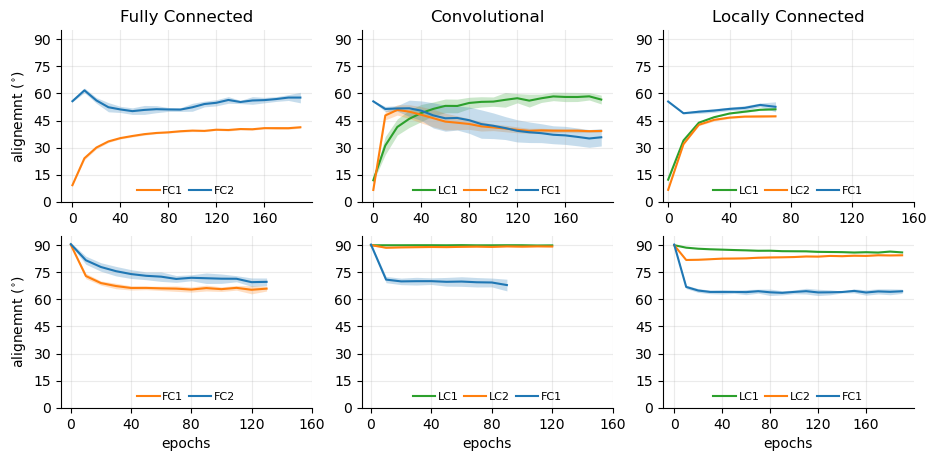

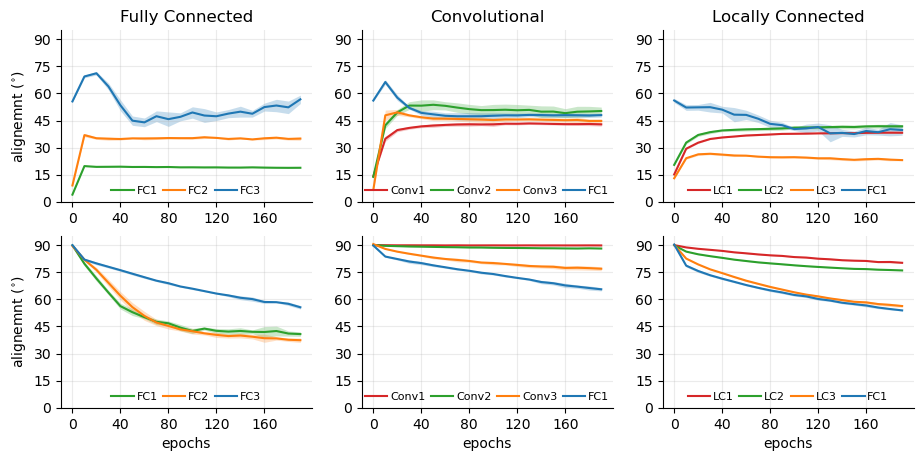

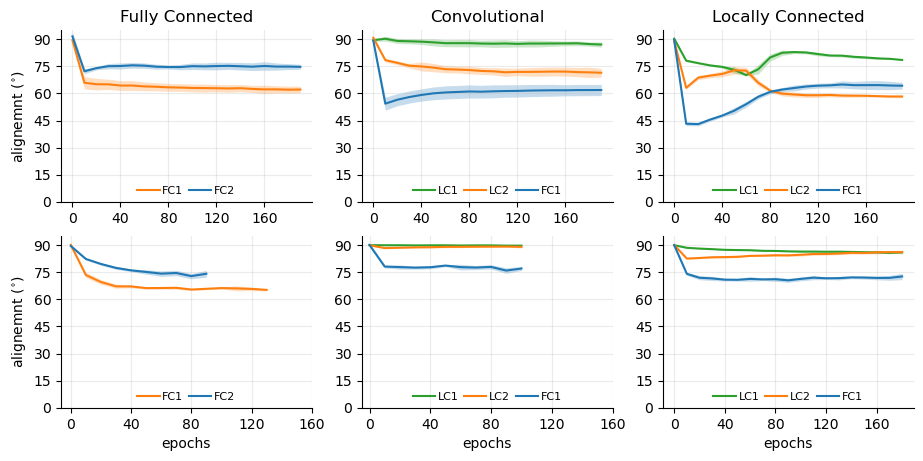

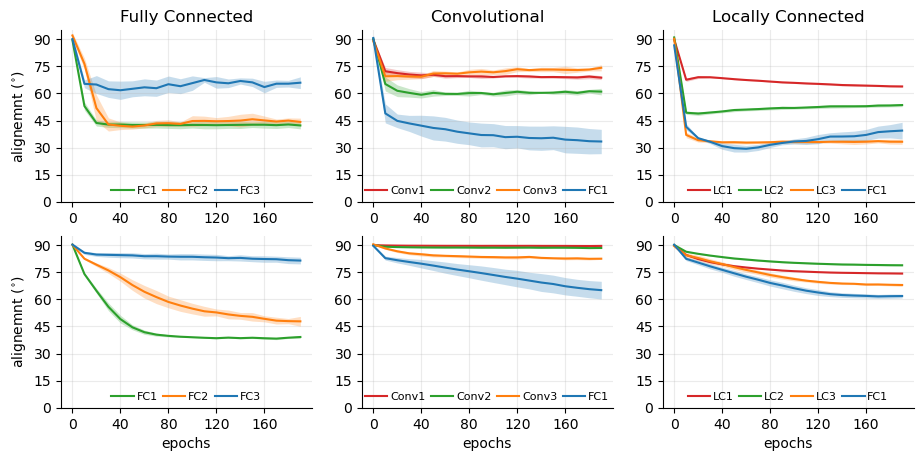

In [17]:
make_plot(0, 1)
plt.savefig('figs/alignment_1.pdf', bbox_inches='tight')
plt.show()

make_plot(1, 1)
plt.savefig('figs/alignment_2.pdf', bbox_inches='tight')
plt.show()

make_plot(0, 0)
plt.savefig('figs/alignment_3.pdf', bbox_inches='tight')
plt.show()

make_plot(1, 0)
plt.savefig('figs/alignment_4.pdf', bbox_inches='tight')
plt.show()